In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using CSV, DataFrames
using PhyML_jll
include(srcdir("helpers.jl"))

compose (generic function with 1 method)

In [2]:
ddir = datadir("exp_raw", "BB669")

"/Users/bend/projects/Doran_etal_2022/data/exp_raw/BB669"

In [3]:
idsdf = CSV.read(joinpath(ddir, "Acc_list.BBIDS_669.csv"), DataFrame);
sdf = CSV.read(joinpath(ddir, "biobank16s.seq_tax.csv"), DataFrame);

In [4]:
bac120aln = readfasta(joinpath(ddir, "gtdbtk.v2.3.0.bac120.user_msa.fasta"));

In [9]:
5035 / 120

41.958333333333336

In [8]:
bac120aln.sequence[1] |> length

5035

In [7]:
unique(bac120aln.sequence)

311-element Vector{String}:
 "RRSIKRLAFPTQKQAEKYDIVNLTSQLAAR" ⋯ 4975 bytes ⋯ "IGTRLGSVPRFKVSAQAKLLEATVAETSAE"
 "RRVIKRIDLGEKRQTDKYDVVNVTAGHGSR" ⋯ 4975 bytes ⋯ "VGGRPHAVPRKKESVQKGLMSAVIYDTANE"
 "RRSIKRLAFPTQKQAEKYDIVNLTSQLAAR" ⋯ 4975 bytes ⋯ "IGTRLGSVPRFKVSAQAKLLEATVAETSAE"
 "RRSIKRLAFPSQKQVEKYDIVNLTSQLAAR" ⋯ 4975 bytes ⋯ "IGTRIGSVPRFKVSAQAKLLEATVAGVAAD"
 "RRSIKRLEFTPQKQVGQYDIVNLKAELGAR" ⋯ 4975 bytes ⋯ "IGTKLGNIPRFKLSASAQLLGATVAKNSGN"
 "RRSIKRLEFPSQKQVEQYDIINLKSELASR" ⋯ 4975 bytes ⋯ "VGTRLGSVPRFKVSAKAKLLEATVAVNSVE"
 "RRSIKRLAFPTQKQAEKYDIVNLTSQLAAR" ⋯ 4975 bytes ⋯ "IGTRIGSVPRFKVSVQAKLLEATVAGVSAD"
 "RRKIRKLEFPEQKQTENYDIINLTASLGAR" ⋯ 4975 bytes ⋯ "VGTRLGSIPRFKLSAQVKLLECTVASAAV-"
 "RRSIKRLEFPSQKQVEQYDIINLKSELASR" ⋯ 4975 bytes ⋯ "VGTRLGSVPRFKVSAKAKLLEATVAVNSVE"
 "RRSIKRLEFTPQKQVGQYDIVNLKAELGAR" ⋯ 4975 bytes ⋯ "IGTKLGNIPRFKLSASAQLLGATVAKNSGN"
 ⋮
 "RRSIKRLAFPSQKQVEKYDIVNLTSQLAAR" ⋯ 4975 bytes ⋯ "IGTRIGSVPRFKVSAQGKLLEATVAGVAAD"
 "RRSIKRLAFPSQKQVEKYDIVNLTSQLAAR" ⋯ 4975 bytes ⋯ "IGTRIGSVPRFKVSAQA

In [5]:
all(!isnothing, indexin(replace.(bac120aln.label, ".prokkaContigs"=>""), idsdf.seq_id))

true

In [6]:
labs = idsdf.msk_id[indexin(replace.(bac120aln.label, ".prokkaContigs"=>""), idsdf.seq_id)]
writephylip(joinpath(ddir, "BB669_bac120.phy"), bac120aln.sequence, labs)

In [20]:
# 2 days 12 hours (60 hours)
inputfile = joinpath(ddir, "BB669_bac120.phy")
outputdir = projectdir("_research", "BB669_bac120_phyml") |> mkpath

cp(inputfile, joinpath(outputdir, basename(inputfile)), force=true)
    
@info "Starting PhyML on BB669_bac120"
# general JTT
@time begin
    run(pipeline(`$(phyml()) \
        -daa -mLG -fe \
        -i $(joinpath(outputdir, basename(inputfile))) \
        -o tlr \
        --search SPR \
        --r_seed 123456 \
        --rand_start \
        --n_rand_starts 3 \
        --no_memory_check \
        --bootstrap -4`, # SH like branch supports
    stdout=joinpath(outputdir, "BB669_bac120" * "_phyml.out")))
end # time phyml

mv(joinpath(outputdir, basename(inputfile) * "_phyml_tree.txt"),
   joinpath(outputdir, basename(inputfile) * "-supporttree.txt")
)

┌ Info: Starting PhyML on BB669_bac120
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/26_bac120tree.ipynb:6


215438.969880 seconds (6.38 M allocations: 176.392 MiB, 0.00% gc time)


"/Users/ben/projects/Doran_etal_2022/_research/BB669_bac120_phyml/BB669_bac120.phy-supporttree.txt"

In [21]:
using NewickTree, NewickTreeTools
using StatsPlots
function ladderize!(t; rev=false)
    function walk!(n)
        if isleaf(n)
            return 1
        else 
            numleaves = [walk!(c) for c in children(n)]
            n.children .= n.children[sortperm(numleaves, rev=rev)]
            return sum(numleaves)
        end        
    end
    walk!(t)
end

ladderize! (generic function with 1 method)

In [22]:
tree = readnw(readline(joinpath(outputdir, basename(inputfile) * "-supporttree.txt")));
ladderize!(tree)

664

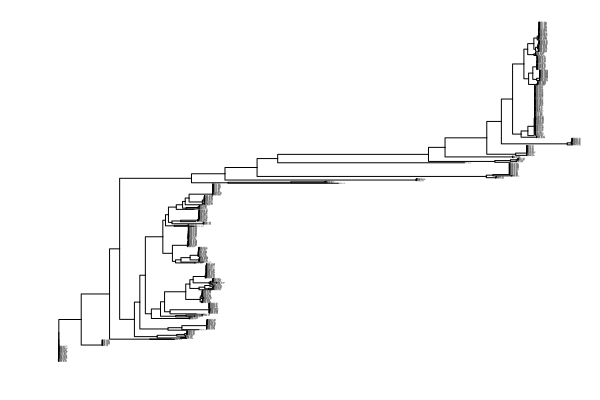

In [23]:
plot(tree, fs=1)

In [24]:
writenw(joinpath(outputdir, basename(inputfile) * "-supporttree_multi.txt"), as_polytomy(n->NewickTree.support(n)<.5, tree))

16066

In [25]:
map(prewalk(tree)) do node
    NewickTree.support(node)>0.5
end

1326-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 1
 0
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0